In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.init import xavier_uniform_, xavier_normal_
import matplotlib.pyplot as plt

from process_data import data, train_data, test_data, item_set
from process_data import TrainDataset, MyDataset, get_dataloader


import warnings
warnings.filterwarnings("ignore")

# 一、NARM搭建

<img src="NARMworkflow.png" style="width:500px;height:300px;">

In [ ]:
class NARM(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size, n_layers=1):
        """
        input_size = output_size = num_item
        """
        super(NARM, self).__init__()

        # === 定义参数 ===
        self.n_items = input_size
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # === 定义layers ===
        # 1. embedding layer
        self.item_embedding = nn.Embedding(self.n_items, self.embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(0.25)
        # 2. GRU layer
        self.gru = nn.GRU(input_size=self.embedding_size,
                          hidden_size=self.hidden_size,
                          num_layers=self.n_layers,
                          bias=False,
                          batch_first=True)
        # 3. attention
        self.A1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.A2 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.v = nn.Linear(self.hidden_size, 1, bias=False)
        self.ct_dropout = nn.Dropout(0.5)
        # 4. feedforward layers
        self.feedforward = nn.Linear(2*self.hidden_size, self.embedding_size)

        # === 初始化参数 ===
        xavier_normal_(self.item_embedding.weight)
        xavier_uniform_(self.gru.weight_hh_l0)
        xavier_uniform_(self.gru.weight_ih_l0)
        xavier_normal_(self.feedforward.weight)

    def forward(self, item_seq, item_seq_len):
        """
        Params:
            item_seq, shape = (batch_size, seq_len)
        Return:
            scores, shape = (batch_size*seq_len, output_size)
        """

        # embedding layer
        seq_embedding = self.item_embedding(item_seq) # [bs, seq_len, emb_size]
        gru_input = self.emb_dropout(seq_embedding)

        # GRU layer
        gru_output, _ = self.gru(gru_input)  # [bs, seq_len, hidden_size]

        mask = item_seq.gt(0)
        # === global encoder ===
        batchsize = mask.shape[0]
        dim0_idx = torch.arange(batchsize).long()  # [0, 1, ..., bs-1]，batch中的每个session
        dim1_idx = torch.sum(mask, 1) - 1  # [bs], 每个session中最后一个item的下标
        c_global = ht = gru_output[dim0_idx, dim1_idx]  # global encoder output, [bs, hidden_size]

        # === local encoder ===
        q1 = self.A1(gru_output)  # [bs, seq_len, hidden_size]
        q2 = self.A2(ht)  # [bs, hidden_size]

        q2 = q2.unsqueeze(1).expand_as(q1)
        mask = mask.unsqueeze(2).expand_as(gru_output)  # [bs, seq_len, hidden_size]
        alpha = self.v(mask * torch.sigmoid(q1 + q2))  # [bs, seq_len, 1]
        c_local = torch.sum(alpha.expand_as(gru_output) * gru_output, 1)  # local encoder output, [bs, hidden_size]

        # concatenate
        c_t = torch.cat([c_local, c_global], 1)
        c_t = self.ct_dropout(c_t)  # [bs, 2*hidden_size]

        # feed forward layer
        output = self.feedforward(c_t)  # [bs, emb_size]

        # 映射回item_size空间
        output = output @ self.item_embedding.weight.T  # [bs, n_items]

        return output

    def predict(self, item_seq):
        """
        Params:
            item_seq, shape = (batch_size, seq_len)
        Return:
            final_score, shape = (batch_size, item_size)
        """
        self.eval()
        with torch.no_grad():
            scores = self.forward(item_seq, item_seq.shape[1])  # [bs, n_items]
        self.train()
        return scores

# 二、模型训练

## 评价指标

In [ ]:
def test_HR_MRR(model, test_dataset, k=20):
    count = 0
    score = 0
    for X, y in test_dataset:
        X = torch.tensor(X, dtype=torch.long).to(device)
        X = X.unsqueeze(0)  # [1, seq_len]

        # 预测
        output = model.predict(X).cpu().detach()  # [1, item_size]
        output = output.squeeze(0)
        top_k = output.topk(k).indices.numpy()

        if y in top_k:
            # HR
            count += 1
            # MRR
            rank_y = np.where(top_k == y)[0][0] + 1
            score += 1 / rank_y

    HR = count / len(test_dataset)
    MRR = score / len(test_dataset)

    return HR, MRR

## 1. 模型训练设置

定义了NARM的`ModelTrain`类，打包训练过程

In [ ]:
class ModelTrain:
    def __init__(self, model, dataset, train_loader, test_loader, optimizer, loss_func, n_epoch):
        self.model = model
        self.train_dataset = dataset[0]
        self.test_dataset = dataset[1]
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.n_epoch = n_epoch

        # 记录loss
        self.train_losses = []
        # 记录test上的准确率
        self.test_acc = []

    def _train_one_epoch(self, epoch):
        train_loss = 0.0
        for batch_idx, batch in enumerate(self.train_loader):
            # 获取batch数据
            X = batch[0].to(device)
            y = batch[1].to(device)  # [bs]

            # 模型预测
            output = self.model(X, X.shape[1])  # [bs, n_items]

            # 反向传播，更新参数
            loss = self.loss_func(output, y.flatten())
            train_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        if epoch % 20 == 0:
            print(f"\nepoch {epoch} ......")
            print(f"train loss = {train_loss:.2f}")
        self.train_losses.append(train_loss)

    def _test_one_epoch(self):
        # 由于test_loader的返回格式和train_loader不同，所以不用loss而是用accuracy来展示test上的效果
        acc = 0
        batch_idx = 0
        for batch_idx, batch in enumerate(self.test_loader):
            X = batch[0].to(device)
            y = batch[1].to(device)
            pred = self.model.predict(X)
            pred = pred.argmax(1).cpu()
            acc += np.sum(pred.numpy() == y.cpu().numpy()) / pred.shape[0]
        acc /= (batch_idx + 1)
        print(f"test accuracy = {acc:.2f}")
        self.test_acc.append(acc)

        # 计算评价指标
        hit_ratio, MRR = test_HR_MRR(self.model, self.test_dataset)
        print(f"MRR = {MRR:.4f} | HR = {hit_ratio:.4%}")

    def train(self, test=False):
        # 记录清零
        self.train_losses = []
        self.test_acc = []
        # 训练
        self.model.train()
        for e in range(self.n_epoch):
            self._train_one_epoch(e)

            # 在test上进行测试，包括accuracy和评价指标的计算
            if e % 20 == 0 and test:
                self.model.eval()
                with torch.no_grad():
                    self._test_one_epoch()
                self.model.train()

    def get_info(self):
        losses = {'train_losses': self.train_losses,
                  'test_acc': self.test_acc}
        return losses

    def plot_train_loss(self):
        plt.figure()
        plt.plot(self.train_losses)
        plt.ylabel('train loss')
        plt.xlabel('epoch')
        plt.show()

    def plot_test_acc(self):
        plt.figure()
        plt.plot(self.test_acc)
        plt.ylabel('test accuracy')
        plt.xlabel('epoch')
        plt.show()

    def plot_performance(self):
        fig = plt.figure(figsize=(14, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.train_losses)
        ax.set_ylabel('train_loss')
        ax.set_xlabel('epoch')
        ax.set_title("train loss change with epoch")

        ax = fig.add_subplot(122)
        ax.plot([i * 20 for i in range(1, len(self.test_acc)+1)], self.test_acc)
        ax.set_ylabel('test_accuracy')
        ax.set_xlabel('epoch')
        ax.set_title("test accuracy change per 20 epoches")

        plt.show()

## 2. 超参数设置

In [ ]:
num_epoch = 101
batch_size = 256
lr = 0.001
embedding_size = 128
hidden_size = 100
item_size = len(item_set) + 1  # +1是因为做了零填充，相当于增加了一个item '0'
output_size = item_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 数据
print(len(train_data), len(test_data))

train_dataset = MyDataset(train_data)
test_dataset = MyDataset(test_data)
print(len(train_dataset), len(test_dataset))

train_loader = get_dataloader(batch_size, dataset=train_dataset, train=False)
test_loader = get_dataloader(batch_size, dataset=test_dataset, train=False)

18055 4514
18055 4514


## 3. 训练和测试

In [ ]:
model1 = NARM(item_size, output_size, embedding_size, hidden_size).to(device)

train1 = ModelTrain(model=model1,
                    dataset=(train_dataset, test_dataset),
                    train_loader=train_loader,
                    test_loader=test_loader,
                    optimizer=torch.optim.Adam(model1.parameters(), lr=lr),
                    loss_func=nn.CrossEntropyLoss(),
                    n_epoch=num_epoch)

train1.train(test=True)


epoch 0 ......
train loss = 643.61
test accuracy = 0.00
MRR = 0.0085 | HR = 3.5002%

epoch 20 ......
train loss = 174.64
test accuracy = 0.04
MRR = 0.0697 | HR = 15.9061%

epoch 40 ......
train loss = 69.53
test accuracy = 0.05
MRR = 0.0756 | HR = 15.9725%

epoch 60 ......
train loss = 45.37
test accuracy = 0.05
MRR = 0.0748 | HR = 15.6845%

epoch 80 ......
train loss = 36.69
test accuracy = 0.05
MRR = 0.0730 | HR = 15.0864%

epoch 100 ......
train loss = 30.73
test accuracy = 0.05
MRR = 0.0733 | HR = 15.0421%


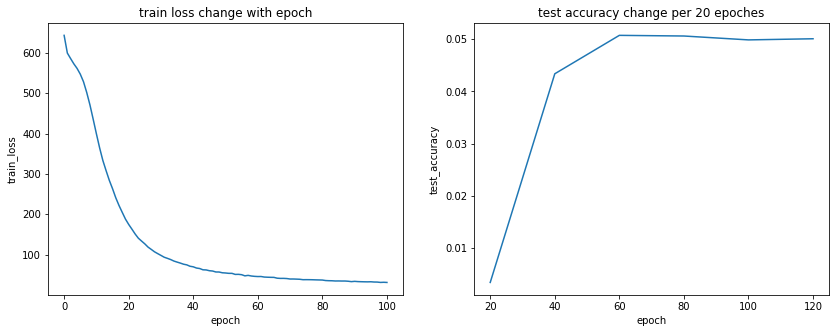

In [ ]:
train1.plot_performance()